In [1]:
!pip install transformers datasets streamlit gradio pandas numpy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Transformer_Project

/content/drive/MyDrive/Transformer_Project


## Load Data

In [4]:
from datasets import load_dataset

# Load the LIAR dataset
dataset = load_dataset("liar")

# Display the first few rows of the training set
print(dataset['train'][0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

liar.py:   0%|          | 0.00/6.41k [00:00<?, ?B/s]

The repository for liar contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/liar.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/10269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1283 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1284 [00:00<?, ? examples/s]

{'id': '2635.json', 'label': 0, 'statement': 'Says the Annies List political group supports third-trimester abortions on demand.', 'subject': 'abortion', 'speaker': 'dwayne-bohac', 'job_title': 'State representative', 'state_info': 'Texas', 'party_affiliation': 'republican', 'barely_true_counts': 0.0, 'false_counts': 1.0, 'half_true_counts': 0.0, 'mostly_true_counts': 0.0, 'pants_on_fire_counts': 0.0, 'context': 'a mailer'}


In [5]:
# Prepare train, validation, and test splits
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

## Data Preprocessing

In [6]:
from transformers import AutoTokenizer
import torch

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Enrich input with metadata
def enrich_input(example):
    # Combine statement with metadata (speaker, party affiliation, and context)
    metadata = f"Speaker: {example['speaker']}, Affiliation: {example['party_affiliation']}, Context: {example['context']}"
    example['enriched_statement'] = f"{example['statement']} [SEP] {metadata}"
    return example

# Apply enrichment to all splits
train_data = train_data.map(enrich_input)
val_data = val_data.map(enrich_input)
test_data = test_data.map(enrich_input)

# Tokenization function for enriched input
def tokenize_data(example):
    return tokenizer(example['enriched_statement'], padding="max_length", truncation=True)

# Ensure labels are integers
def convert_labels_to_int(example):
    example['label'] = int(example['label'])  # Convert tensor to integer
    return example

# Apply tokenization and label conversion to all splits
train_data = train_data.map(convert_labels_to_int).map(tokenize_data, batched=True)
val_data = val_data.map(convert_labels_to_int).map(tokenize_data, batched=True)
test_data = test_data.map(convert_labels_to_int).map(tokenize_data, batched=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10269 [00:00<?, ? examples/s]

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

Map:   0%|          | 0/1283 [00:00<?, ? examples/s]

Map:   0%|          | 0/10269 [00:00<?, ? examples/s]

Map:   0%|          | 0/10269 [00:00<?, ? examples/s]

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

Map:   0%|          | 0/1283 [00:00<?, ? examples/s]

Map:   0%|          | 0/1283 [00:00<?, ? examples/s]

In [7]:
# Verify label format
print(set(train_data['label']))  # Should output: {0, 1, 2, 3, 4, 5}

{0, 1, 2, 3, 4, 5}


In [8]:
# Format the data for PyTorch
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"], output_all_columns=False)
val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"], output_all_columns=False)
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"], output_all_columns=False)

In [9]:
print(train_data['label'])  # Expected: tensor([0, 1, 2, 3, 4, 5])

tensor([0, 1, 2,  ..., 1, 0, 5])


## Load Model

In [10]:
from transformers import AutoModelForSequenceClassification

# Load the pre-trained BERT model with 6 classification labels
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
# Training Arguements
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",              # Directory to save the model
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",              # Save the model at the end of each epoch
    learning_rate=2e-5,                 # Initial learning rate
    per_device_train_batch_size=16,     # Batch size for training
    per_device_eval_batch_size=16,      # Batch size for evaluation
    num_train_epochs=3,                 # Number of training epochs
    weight_decay=0.01,                  # Weight decay for regularization
    logging_dir="./logs",               # Directory for logs
    logging_steps=10,                   # Log training metrics every 10 steps
    save_total_limit=2,                 # Save only the last 2 models
    fp16=True,                          # Enable mixed precision training for faster training
    load_best_model_at_end=True,        # Automatically load the best model at the end of training
    metric_for_best_model="f1",         # Use F1 score to determine the best model
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
# Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score

# Define evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # Get predicted class
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")  # Weighted for multi-class
    return {"accuracy": acc, "f1": f1}

In [13]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Initialize training
from transformers import Trainer

# Initialize the Trainer
trainer = Trainer(
    model=model,                        # Pre-trained BERT model
    args=training_args,                 # Training arguments
    train_dataset=train_data,           # Training dataset
    eval_dataset=val_data,              # Validation dataset
    compute_metrics=compute_metrics,    # Evaluation metrics
)

In [14]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.675500,1.692318,0.260903,0.221303
2,1.597300,1.638869,0.291277,0.277920
3,1.531600,1.677002,0.303738,0.302583


TrainOutput(global_step=1926, training_loss=1.6156151401167222, metrics={'train_runtime': 879.5633, 'train_samples_per_second': 35.025, 'train_steps_per_second': 2.19, 'total_flos': 8105953392359424.0, 'train_loss': 1.6156151401167222, 'epoch': 3.0})

In [15]:
val_results = trainer.evaluate(val_data)
print("Validation Results:", val_results)

test_results = trainer.evaluate(test_data)
print("Test Results:", test_results)

Validation Results: {'eval_loss': 1.6770015954971313, 'eval_accuracy': 0.3037383177570093, 'eval_f1': 0.3025831687795238, 'eval_runtime': 9.8077, 'eval_samples_per_second': 130.918, 'eval_steps_per_second': 8.259, 'epoch': 3.0}
Test Results: {'eval_loss': 1.6396052837371826, 'eval_accuracy': 0.2837100545596259, 'eval_f1': 0.2817356780986203, 'eval_runtime': 10.2011, 'eval_samples_per_second': 125.771, 'eval_steps_per_second': 7.94, 'epoch': 3.0}


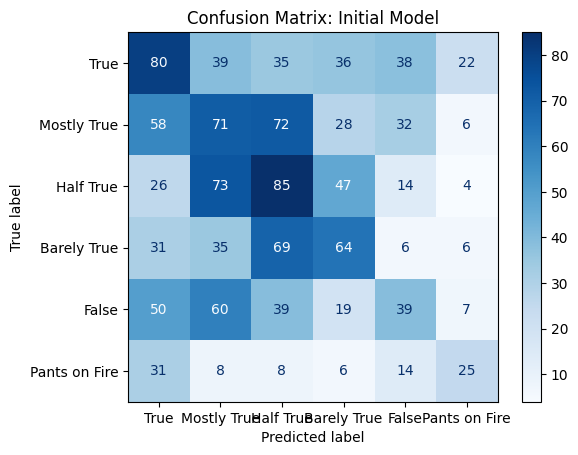

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt


# Predict on test data
preds = trainer.predict(test_data)
y_pred = preds.predictions.argmax(-1)
y_true = test_data["label"]

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["True", "Mostly True", "Half True", "Barely True", "False", "Pants on Fire"])
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix: Initial Model")
plt.show()

## Improve Model

In [17]:
from collections import Counter
from torch import tensor

# Calculate label frequencies
train_labels = [example['label'] for example in train_data]
label_counts = Counter(train_labels)
total_samples = sum(label_counts.values())

# Compute class weights
class_weights = {label: total_samples / count for label, count in label_counts.items()}
weight_tensor = tensor([class_weights.get(tensor(i), 1.0) for i in range(6)], dtype=torch.float)
print("Class Weights:", class_weights)

Class Weights: {tensor(0): 10269.0, tensor(1): 10269.0, tensor(2): 10269.0, tensor(0): 10269.0, tensor(1): 10269.0, tensor(3): 10269.0, tensor(4): 10269.0, tensor(1): 10269.0, tensor(1): 10269.0, tensor(2): 10269.0, tensor(2): 10269.0, tensor(1): 10269.0, tensor(0): 10269.0, tensor(2): 10269.0, tensor(4): 10269.0, tensor(1): 10269.0, tensor(3): 10269.0, tensor(4): 10269.0, tensor(1): 10269.0, tensor(2): 10269.0, tensor(0): 10269.0, tensor(2): 10269.0, tensor(2): 10269.0, tensor(1): 10269.0, tensor(4): 10269.0, tensor(0): 10269.0, tensor(2): 10269.0, tensor(1): 10269.0, tensor(0): 10269.0, tensor(2): 10269.0, tensor(3): 10269.0, tensor(4): 10269.0, tensor(0): 10269.0, tensor(2): 10269.0, tensor(2): 10269.0, tensor(3): 10269.0, tensor(3): 10269.0, tensor(3): 10269.0, tensor(5): 10269.0, tensor(3): 10269.0, tensor(0): 10269.0, tensor(1): 10269.0, tensor(5): 10269.0, tensor(5): 10269.0, tensor(0): 10269.0, tensor(1): 10269.0, tensor(5): 10269.0, tensor(0): 10269.0, tensor(5): 10269.0, tens

In [18]:
from torch.nn import CrossEntropyLoss

# Create a weighted loss function
loss_fn = CrossEntropyLoss(weight=weight_tensor)

# Custom Trainer to use the weighted loss
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None): # Added num_items_in_batch argument
        labels = inputs.pop("labels").to(model.device)
        outputs = model(**inputs)
        logits = outputs.logits

        # Move weights to the model's device
        loss_fn.weight = weight_tensor.to(model.device)

        # Compute the loss
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

# Initialize the CustomTrainer
improved_trainer = CustomTrainer(
    model=model,                        # Same pre-trained BERT model
    args=training_args,                 # Use the same training arguments
    train_dataset=train_data,           # Training dataset
    eval_dataset=val_data,              # Validation dataset
    tokenizer=tokenizer,                # Tokenizer
    compute_metrics=compute_metrics     # Evaluation metrics
)


<ipython-input-18-3dcc8a121750>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  improved_trainer = CustomTrainer(


In [19]:
# Retrain with weighted loss
improved_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.375000,1.787101,0.271807,0.272947
2,1.031800,1.993693,0.280374,0.282220
3,1.029300,2.156515,0.278037,0.278380


TrainOutput(global_step=1926, training_loss=1.1107187464229786, metrics={'train_runtime': 833.7926, 'train_samples_per_second': 36.948, 'train_steps_per_second': 2.31, 'total_flos': 8105953392359424.0, 'train_loss': 1.1107187464229786, 'epoch': 3.0})

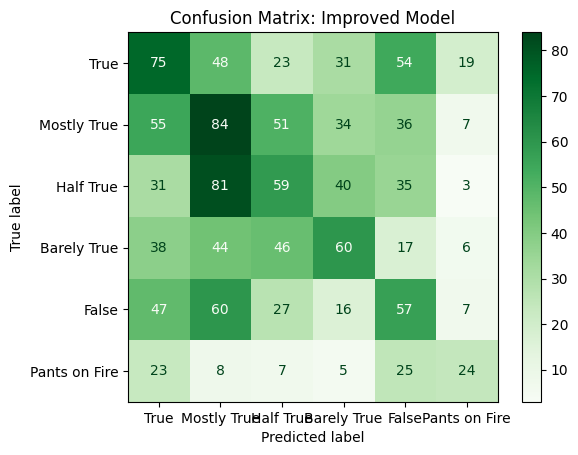

In [20]:
# Predict on test data with the improved model
improved_preds = improved_trainer.predict(test_data)
y_pred_improved = improved_preds.predictions.argmax(-1)

# Generate confusion matrix for improved model
cm_improved = confusion_matrix(y_true, y_pred_improved, labels=[0, 1, 2, 3, 4, 5])
disp_improved = ConfusionMatrixDisplay(confusion_matrix=cm_improved, display_labels=["True", "Mostly True", "Half True", "Barely True", "False", "Pants on Fire"])
disp_improved.plot(cmap="Greens")
disp_improved.ax_.set_title("Confusion Matrix: Improved Model")
plt.show()

In [21]:
val_results_improved = improved_trainer.evaluate(val_data)
test_results_improved = improved_trainer.evaluate(test_data)

print("Improved Validation Results:", val_results_improved)
print("Improved Test Results:", test_results_improved)

Improved Validation Results: {'eval_loss': 1.993693470954895, 'eval_accuracy': 0.2803738317757009, 'eval_f1': 0.282219647604737, 'eval_runtime': 9.7981, 'eval_samples_per_second': 131.045, 'eval_steps_per_second': 8.267, 'epoch': 3.0}
Improved Test Results: {'eval_loss': 1.9200012683868408, 'eval_accuracy': 0.2798129384255651, 'eval_f1': 0.27985061799288274, 'eval_runtime': 10.024, 'eval_samples_per_second': 127.993, 'eval_steps_per_second': 8.081, 'epoch': 3.0}


## Fine-Tune Hyperparameters

In [22]:
# Fine-tuning training arguments
fine_tuned_args = TrainingArguments(
    output_dir="./results_fine_tune",   # New directory for fine-tuned model
    evaluation_strategy="epoch",       # Evaluate after every epoch
    save_strategy="epoch",             # Save model after every epoch
    learning_rate=1e-5,                # Lower learning rate for stability
    per_device_train_batch_size=8,     # Smaller batch size for more stability
    per_device_eval_batch_size=8,      # Smaller evaluation batch size
    gradient_accumulation_steps=2,     # Simulate larger batch sizes
    num_train_epochs=5,                # Train for more epochs
    weight_decay=0.1,                  # Increased weight decay for regularization
    fp16=True,                         # Use mixed precision training
    logging_dir="./logs_fine_tune",    # Directory for new logs
    load_best_model_at_end=True,       # Automatically load the best model
    metric_for_best_model="f1",        # Optimize for F1 score
    save_total_limit=2,                # Save only the last 2 models
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
# Initialize the Trainer with fine-tuned arguments
fine_tuned_trainer = Trainer(
    model=model,                        # Use the current pre-trained model
    args=fine_tuned_args,               # Training arguments for fine-tuning
    train_dataset=train_data,           # Training dataset
    eval_dataset=val_data,              # Validation dataset
    tokenizer=tokenizer,                # Tokenizer
    compute_metrics=compute_metrics     # Metrics for evaluation
)

<ipython-input-23-4cfb7d8e7a1a>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  fine_tuned_trainer = Trainer(


In [24]:
# Train the model
fine_tuned_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.005400,2.220448,0.267913,0.267047
2,0.846100,2.366481,0.267913,0.269710
3,0.752700,2.573278,0.269470,0.268102
4,0.527800,2.728199,0.270249,0.270837
5,0.461400,2.785793,0.265576,0.266232


TrainOutput(global_step=3210, training_loss=0.6895414952548493, metrics={'train_runtime': 1442.8876, 'train_samples_per_second': 35.585, 'train_steps_per_second': 2.225, 'total_flos': 1.350992232059904e+16, 'train_loss': 0.6895414952548493, 'epoch': 5.0})

In [27]:
# Evaluate on the test set
val_results_fine_tuned = fine_tuned_trainer.evaluate(val_data)
print("Validation Results (Fine-Tuned):", val_results_fine_tuned)
final_test_results = fine_tuned_trainer.evaluate(test_data)
print("Final Test Results:", final_test_results)

Validation Results (Fine-Tuned): {'eval_loss': 2.7281992435455322, 'eval_accuracy': 0.2702492211838006, 'eval_f1': 0.2708371294400091, 'eval_runtime': 9.1971, 'eval_samples_per_second': 139.609, 'eval_steps_per_second': 17.506, 'epoch': 5.0}
Final Test Results: {'eval_loss': 2.6461384296417236, 'eval_accuracy': 0.2735775526110678, 'eval_f1': 0.2723843717072074, 'eval_runtime': 9.2841, 'eval_samples_per_second': 138.194, 'eval_steps_per_second': 17.342, 'epoch': 5.0}


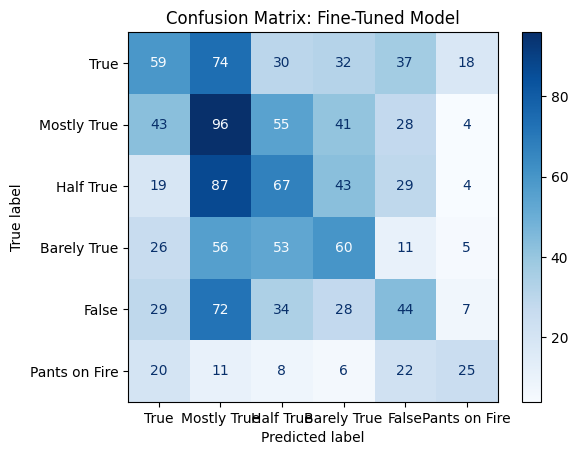

In [26]:
preds = fine_tuned_trainer.predict(test_data)
y_pred = preds.predictions.argmax(-1)
y_true = test_data["label"]

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["True", "Mostly True", "Half True", "Barely True", "False", "Pants on Fire"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Fine-Tuned Model")
plt.show()

In [28]:
# Save the best-performing model
fine_tuned_trainer.save_model("./best_model")

## Simple Demo

In [34]:
import gradio as gr
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("./best_model")
tokenizer = AutoTokenizer.from_pretrained("./best_model")

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prediction function with enriched metadata
def predict_label(statement, speaker, affiliation, context):
    # Enrich the input with metadata
    metadata = f"Speaker: {speaker}, Affiliation: {affiliation}, Context: {context}"
    enriched_statement = f"{statement} [SEP] {metadata}"

    # Tokenize the enriched input
    inputs = tokenizer(enriched_statement, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device

    # Get predictions from the model
    outputs = model(**inputs)
    prediction = outputs.logits.argmax(-1).item()

    # Map prediction to label
    labels = ["false", "barely-true", "half-true", "mostly-true", "true", "pants-fire"]
    return f"Predicted Label: {labels[prediction]}"

# Gradio Interface
demo = gr.Interface(
    fn=predict_label,
    inputs=[
        gr.Textbox(label="Statement", placeholder="Enter the news statement."),
        gr.Textbox(label="Speaker", placeholder="Enter the speaker's name."),
        gr.Textbox(label="Affiliation", placeholder="Enter the speaker's political affiliation."),
        gr.Textbox(label="Context", placeholder="Enter additional context for the statement."),
    ],
    outputs="text",
    title="Fact-Checking Classification",
    description=(
        "This model classifies news statements into six categories: True, Mostly True, Half True, Barely True, False, "
        "and Pants on Fire. The model incorporates metadata (speaker, affiliation, and context) to improve predictions. "
        "Note: Due to dataset complexity, the model achieves less than 30% accuracy."
    )
)

# Launch the Gradio app
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cd1ff92b9180086401.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
